In [1]:
!pip install pytorch-tabnet
!pip install wget
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path


%load_ext autoreload

%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.13.1 w

Скачивание набора данных об истории покупок электронной коммерции в магазине электроники

In [2]:
train = pd.read_csv('Table 1.csv')

Загрузка данных и разделение на 3 выборки для дальнейшей работы

In [3]:
target = 'order_id'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index
dataset_name = 'electronics-store'

Простая предварительная обработка

Метки кодируют категориальные функции и заполняют пустые ячейки

In [4]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Set 3


Определение категориальных признаков

In [5]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice
cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10]

Параметры нейронной сети

In [6]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


###Обучение

In [7]:
n_targets = 8

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]
y_train = np.transpose(np.tile(y_train, (n_targets,1)))

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]
y_valid = np.transpose(np.tile(y_valid, (n_targets,1)))

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]
y_test = np.transpose(np.tile(y_test, (n_targets,1)))

In [8]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [9]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
) 

epoch 0  | loss: inf     | train_rmsle: 1413.2974| train_mae: 2.33883832167979e+18| train_rmse: 2.338889178577939e+18| train_mse: 5.470402589668987e+36| valid_rmsle: 1413.29337| valid_mae: 2.3390061892608896e+18| valid_rmse: 2.3390561749561165e+18| valid_mse: 5.471183789600339e+36|  0:00:09s
epoch 1  | loss: nan     | train_rmsle: 1470.81752| train_mae: 2.33883832167979e+18| train_rmse: 2.338889178577939e+18| train_mse: 5.470402589668987e+36| valid_rmsle: 1470.80575| valid_mae: 2.3390061892608896e+18| valid_rmse: 2.3390561749561165e+18| valid_mse: 5.471183789600339e+36|  0:00:22s
epoch 2  | loss: nan     | train_rmsle: 1496.21463| train_mae: 2.33883832167979e+18| train_rmse: 2.338889178577939e+18| train_mse: 5.470402589668987e+36| valid_rmsle: 1496.05425| valid_mae: 2.3390061892608896e+18| valid_rmse: 2.3390561749561165e+18| valid_mse: 5.471183789600339e+36|  0:00:28s
epoch 3  | loss: nan     | train_rmsle: 1513.77942| train_mae: 2.33883832167979e+18| train_rmse: 2.338889178577939e+18|

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [10]:
preds = clf.predict(X_test)

test_mse = mean_squared_error(y_pred=preds, y_true=y_test)

print(f"ЛУЧШАЯ ПРАВИЛЬНАЯ ОЦЕНКА ДЛЯ {dataset_name} : {clf.best_cost}")
print(f"ФИНАЛЬНАЯ ТЕСТОВАЯ ОЦЕНКА ДЛЯ {dataset_name} : {test_mse}")

ЛУЧШАЯ ПРАВИЛЬНАЯ ОЦЕНКА ДЛЯ electronics-store : 5.471183789600339e+36
ФИНАЛЬНАЯ ТЕСТОВАЯ ОЦЕНКА ДЛЯ electronics-store : 5.47029399695197e+36


###Сохранение модели и загрузка

In [11]:
clf.feature_importances_

array([0.       , 0.8483379, 0.1516621, 0.       ])

In [12]:
explain_matrix, masks = clf.explain(X_test)

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

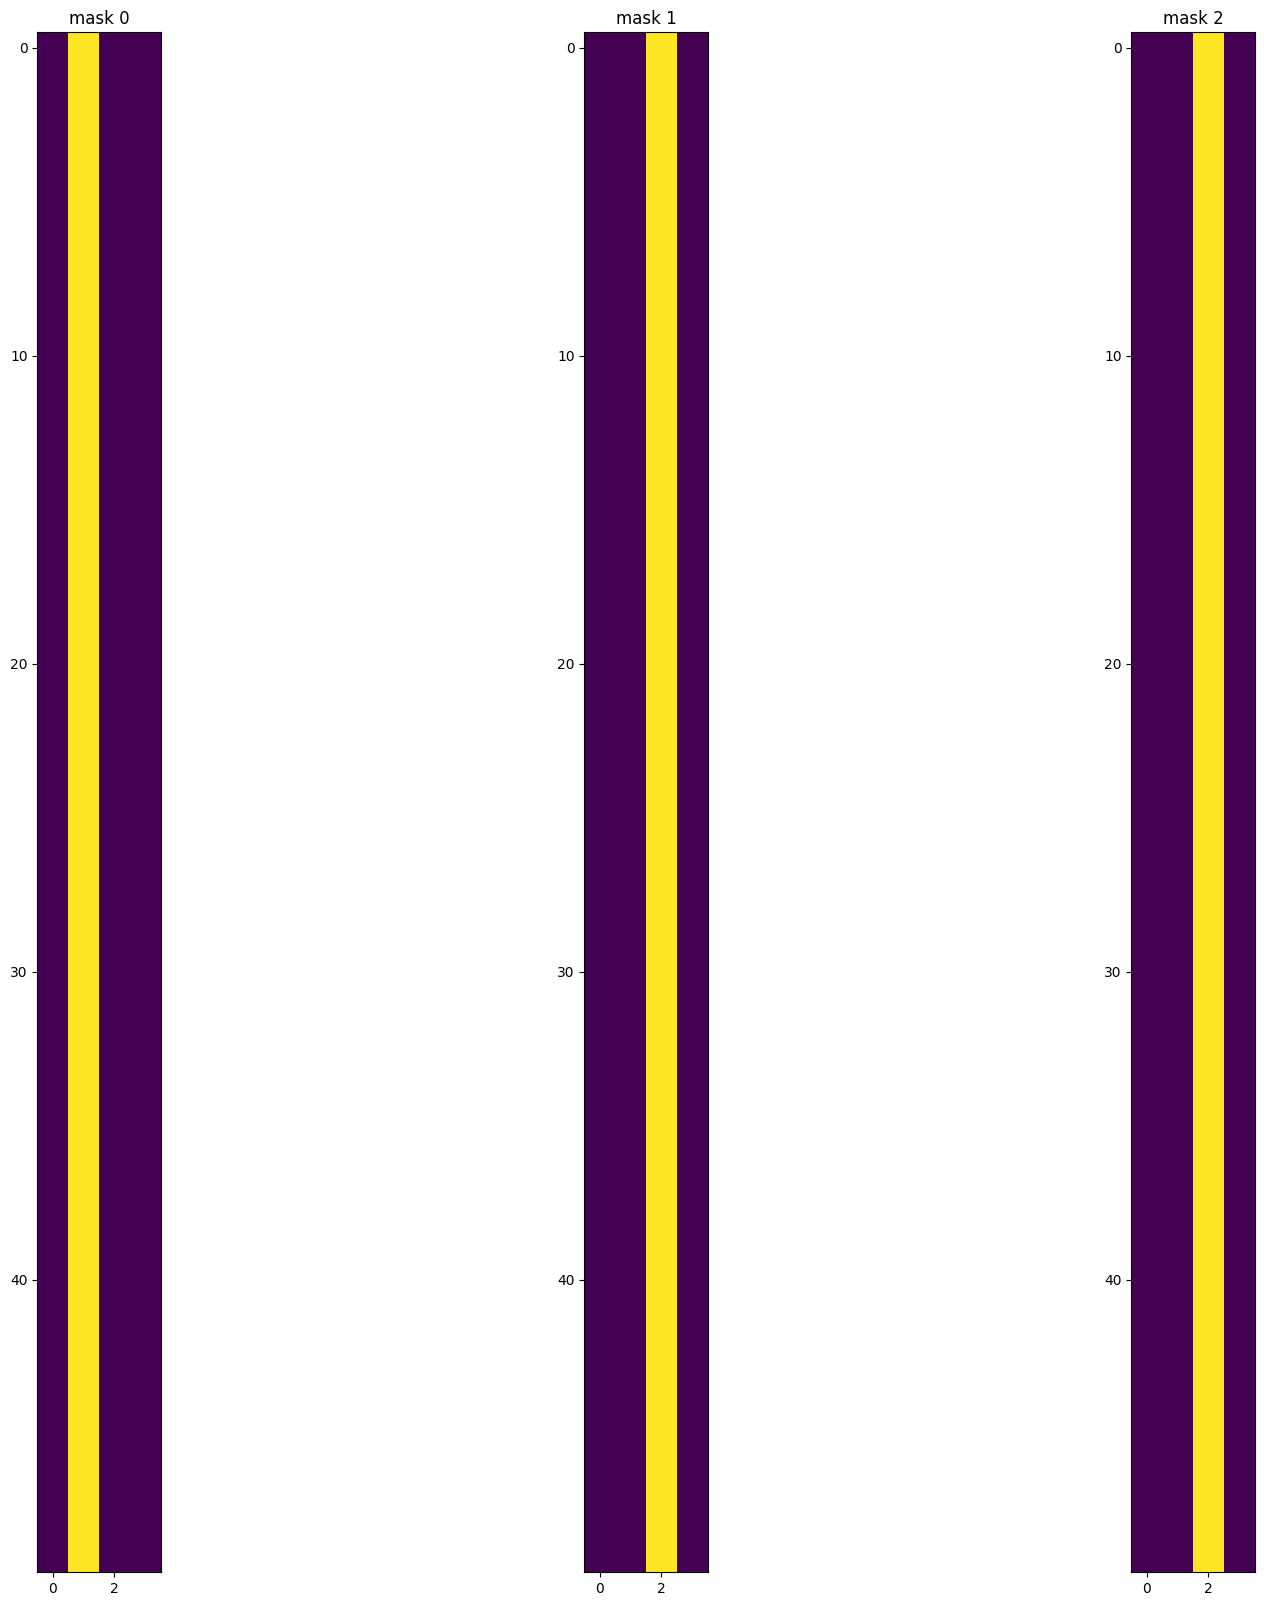

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")